**<font color = black size=6>实验七:聚类</font>**

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
import warnings
import random
warnings.filterwarnings('ignore')
from pandas.core.frame import DataFrame
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

**<font color = blue size=4>第一部分:实验任务</font>**

本任务使用train.csv数据集，共有二维特征【weight】,【height】.本次实验检测使用二类聚类算法: 原型聚类法【K-means】和密度聚类法【DBSCAN】.

1)对该数据集进行聚类处理

2)聚类完成后进行可视化处理

由于层次聚类法计算量大，复杂度高，本次实验任务不做要求，感兴趣的同学可以自行实现。

<span style="color:purple">1.首先编写计算衡量样本间的相似度的距离，这里列举两种距离公式.之后的任务中从两个距离公式中选择一种使用，但需要保证两个任务要使用同样的距离公式</span>
    
<span style="color:purple">a.曼哈顿距离计算公式:  
    对于两个d维的样本$x_i$,$x_j$,他们的曼哈顿距离计算公式为:  
    $$dist_{man}(x_i,x_j)=\sum_{u=1}^d |x_{iu}-x_{ju}|$$
其中$x_{iu}$和$x_{ju}$分别为样本$x_i$和$x_j$的第u维特征值</span>

<span style="color:purple">b.欧式距离计算公式:  
    对于两个d维的样本$x_i$,$x_j$,他们的欧式距离计算公式为:  
    $$dist_{ed}(x_i,x_j)=\sqrt{\sum_{u=1}^d (x_{iu}-x_{ju})^2}$$
其中$x_{iu}$和$x_{ju}$分别为样本$x_i$和$x_j$的第u维特征值</span>

In [206]:
#曼哈顿距离
def manhattan_distance(x, y):
    
    # 初始化
    dist = 0
    
    # 累加
    for i in range(len(x)):
        dist += abs(x[i]-y[i])

    return dist 

#欧式距离
def euclidean_distance(x,y):
    
    # 初始化
    dist = 0
    
    # 累加
    for i in range(len(x)):
        dist += (x[i]-y[i])**2

    # 开根
    dist = math.sqrt(dist)

    return dist

In [207]:
def avg_intra_cluster_distance(cluster):
    n = len(cluster)
    if n <= 1:
        return 0.0
    
    avg_dist = 0.0

    for i in range(n):
        for j in range(i+1, n):
            avg_dist += manhattan_distance(cluster[i], cluster[j])
    avg_dist = (2.0 / (n * (n - 1))) * avg_dist

    return avg_dist

def davies_bouldin_index(cluster_centers, clusters):
    k = len(cluster_centers)
    dbi = 0.0

    for i in range(k):
        max_dbi = 0.0
        for j in range(k):
            if i != j :
                centroid_i = cluster_centers[i]
                centroid_j = cluster_centers[j]
                avg_distance_i = avg_intra_cluster_distance(clusters[i])
                avg_distance_j = avg_intra_cluster_distance(clusters[j])
                distance_centers = manhattan_distance(centroid_i, centroid_j)
                dbi_temp = (avg_distance_i + avg_distance_j) / distance_centers
                if dbi_temp > max_dbi:
                    max_dbi = dbi_temp
        dbi += max_dbi
    
    dbi /= k

    return dbi

**<font color = green size=3>1):常用聚类算法一: 原型聚类法</font>**

使用K-means算法对数据集进行聚类处理，具体逻辑参照下面图片所给的伪代码

In [208]:
%%html
<img src="K_means Pseudocode.png", width=720, heigth=240>

<span style="color:purple">1)
确定聚类数量$k$，然后从数据集D中随机选取 $k$ 个样本作为初始均值向量$\{\mu_1,\mu_2,...,\mu_{k}\}$ </span>

        Weight      Height
0    67.062924  176.086355
1    68.804094  178.388669
2    60.930863  170.284496
3    59.733843  168.691992
4    65.431230  173.763679
..         ...         ...
495  59.976983  169.679741
496  66.423814  174.625574
497  53.604698  161.919208
498  50.433644  160.794875
499  60.224392  169.689709

[500 rows x 2 columns]


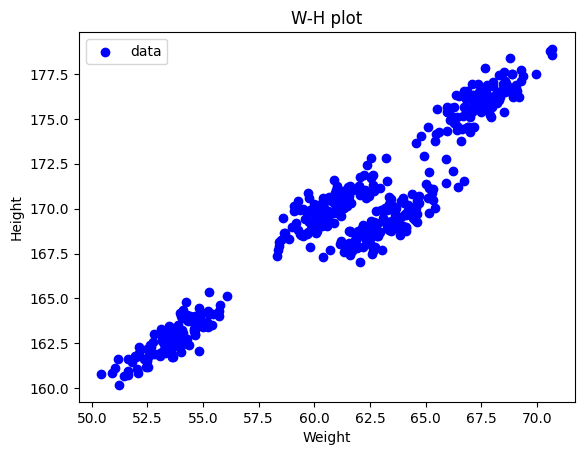

In [209]:
# 加载数据集
train_data = pd.read_csv("train.csv")
print(train_data)

# 作图，判断聚类数量
feature = train_data.iloc[:,:-1]
label = train_data.iloc[:,-1]

# 创建散点图
plt.scatter(feature, label, label='data', color='blue', marker='o')

plt.xlabel('Weight')
plt.ylabel('Height')

plt.title('W-H plot')
plt.legend()
plt.show()


In [210]:
# 聚类数量
k = 3

# 随机选取k个样本作为初始均值向量
init_cents = random.sample(range(len(train_data)), k)

# 初始化每个聚类的簇心向量
cents = [train_data.iloc[i].values for i in init_cents]

# 初始化各个聚类集合
clusters = [[] for _ in range(k)]


<span style="color:purple">2)开始进行迭代。每一轮更新均值向量，直到均值向量不再变化则停止迭代</span>

<span style="color:purple">迭代步骤1).
遍历每个样本$x_j$,计算其与当前的各个均值向量$\mu_i$的距离$d_{ji}$，比较与每个均值向量的距离大小:$$\lambda_j=arg min_{i \in \{1,2,...,k\} }d_{ji}$$</span>

<span style="color:purple">将其划入与其距离最近的簇中,$$ C_{\lambda_j} = C_{\lambda_j}\bigcup{x_j} $$</span>
<span style="color:purple">迭代步骤2).
将所有样本划分完成生成k个簇 $\{C_1,C_2,...,C_k\}$对于每个簇$C_i$，计算该簇的新均值向量，公式为:$$\mu_i^{'}=\frac{1}{|C_i|}\sum_{x \in C_i}x$$ </span>
<span style="color:purple">迭代步骤3).
将更新的均值向量$\{\mu_1^{'},\mu_2^{'},...,\mu_k^{'}\}$与该轮未更新前的均值向量$\{\mu_1,\mu_2,...,\mu_k\}$进行比较.  如果完全一样，则结束迭代；如果不一样，则继续迭代.</span>

In [211]:
# 比较均值向量是否相同
def equallist(x,y):
    return all(np.array_equal(x[i], y[i]) for i in range(k))

#迭代过程
while True:
    
    #初始化
    new_clusters = [[] for _ in range(k)]
        
    #计算每个样本与k个聚类的簇心的距离，将其划入距离最近的簇
    for i in range(len(train_data)):
        dists = [manhattan_distance(train_data.iloc[i].values, cent) for cent in cents]
        new_clusters[np.argmin(dists)].append(train_data.iloc[i].values)
    
    #更新这轮迭代的簇心
    new_cents = [np.mean(cluster, axis=0) if cluster else cents[i] for i, cluster in enumerate(new_clusters)]

    if equallist(clusters, new_clusters):
        break
    
    cents = new_cents
    clusters = new_clusters

#输出划分的聚类情况   
for i in range(k):
    print(f'Cluster {i + 1}:')
    for data_point in clusters[i]:
        print(data_point)



Cluster 1:
[ 53.40785962 162.75684311]
[ 53.44601711 162.91516701]
[ 53.96476395 162.4905542 ]
[ 53.55139341 162.25694859]
[ 54.83092473 163.76973667]
[ 54.18683143 164.03403131]
[ 53.55726809 162.19776822]
[ 54.01520331 162.03712437]
[ 52.06898888 160.86332119]
[ 53.51571683 162.70617729]
[ 53.29266169 162.82407434]
[ 53.29334143 161.95139649]
[ 54.24470276 164.80994214]
[ 54.57705626 163.18742968]
[ 51.62855362 161.63787711]
[ 51.79823342 161.47779743]
[ 52.1307295  162.29861918]
[ 53.61670245 162.75825099]
[ 54.20840156 162.69854341]
[ 53.35527708 162.01297159]
[ 54.45472275 163.98492748]
[ 53.88228842 162.99110965]
[ 53.71377385 162.85307939]
[ 55.46345663 164.10459318]
[ 54.08461307 163.06290255]
[ 52.1346691  161.93511671]
[ 54.62612906 163.0145684 ]
[ 54.06062459 163.93426098]
[ 54.6434248 163.3475803]
[ 53.99848734 163.00088844]
[ 54.07585096 163.23958942]
[ 54.62194554 163.34390043]
[ 52.84806374 161.88989222]
[ 53.50985446 162.56685805]
[ 53.68859732 163.12301025]
[ 54.099318

<span style="color:purple">3)判断是否有空簇,返回所有非空的簇,空簇丢弃</span>

In [212]:
#your code here
non_empty_clusters = [cluster for cluster in clusters if cluster]
        

<span style="color:purple">4)将数据集的二维特征值作为绘图的横纵坐标，将所有样本绘制到一张图中，其中同一聚类的样本点绘制为相同颜色</span>

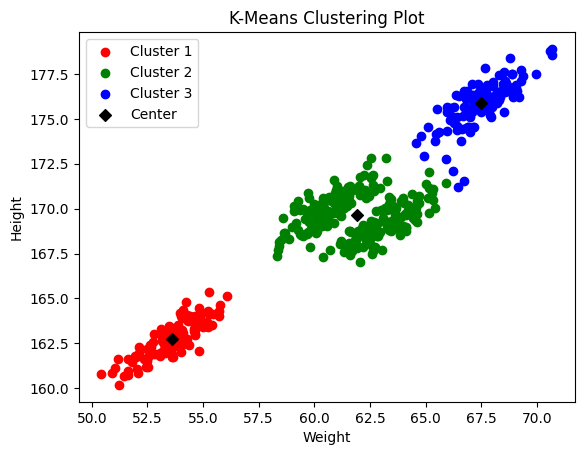

DBI指数为 0.45408582584051177


In [213]:
#your code here
colors = ['r', 'g', 'b', 'c']

for i, cluster in enumerate(non_empty_clusters):
    x = [point[0] for point in cluster] 
    y = [point[1] for point in cluster]
    plt.scatter(x, y, c=colors[i], label=f'Cluster {i + 1}')

cluster_cent_x = [cents[i][0] for i in range(len(cents))]
cluster_cent_y = [cents[i][1] for i in range(len(cents))]
plt.scatter(cluster_cent_x, cluster_cent_y, label='Center', color='k', marker='D')

plt.legend()
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('K-Means Clustering Plot')
plt.show()

print("DBI指数为",davies_bouldin_index(cents,non_empty_clusters))

**<font color = green size=3>2):常用聚类算法二: 密度聚类法</font>**

本任务依然使用train.csv数据集，使用DBSCAN算法对数据集进行聚类处理，具体逻辑参照"图片2:DBSCAN伪代码"中的伪代码

<span style="color:purple">1)首先编写函数,根据“邻域”参数（epsilon,MinPts），输出该样本的领域对象的样本索引列表.    
    【输入】：输入数据集D、当前样本的索引index、 邻域半径epsilon   
    【输出】：该样本的邻域对象的样本索引列表</span>

In [214]:
def get_neighbors(D, index, epsilon):
    neighbors = []
    
    # 遍历所有样本
    for i in range(len(D)) :
        # 如果样本与当前样本的距离小于等于邻域半径，则将其加入邻域内
        if manhattan_distance(D[index], D[i]) <= epsilon:
            neighbors.append(i)

    return neighbors

<span style="color:purple">2)编写函数,根据“邻域”参数（epsilon,MinPts），输出数据集D的所有的核心对象.    
    【输入】：输入数据集D、当前样本的索引index、邻域参数（epsilon,MinPts）   
    【输出】：该数据集D的所有的核心对象</span>

In [215]:
def core_set(D, epsilon, MinPts):
    # 初始化核心对象集合
    core_objects = set()

    # 遍历每个样本
    for i in range(len(D)):
        # 获取邻域内的所有样本的索引
        neighbors = get_neighbors(D, i, epsilon)

        # 如果邻域内的样本数量大于等于最小样本数，则将当前样本标记为核心对象
        if len(neighbors) >= MinPts:
            core_objects.add(i)  # 使用add将索引添加到集合

    return core_objects

<span style="color:purple">3)遍历核心对象集合中的所有元素，直至所有核心对象被访问,具体逻辑参照下面图片的伪代码</span>

In [216]:
%%html
<img src="DBSCAN Pseudocode.png", width=720, heigth=240>

In [217]:
#初始化参数epsilon,MinPts
D = train_data.values
epsilon = 0.7
MinPts = 5

# 初始化标签数组，0表示未分类
labels = [0] * len(D)

# 生成核心对象集合
core_objects = core_set(D, epsilon, MinPts)

# 定义当前簇的标签
cur_cluster = 0

# 对核心对象集合进行遍历
for i in core_objects :
    
    # 如果核心对象已经分类，则跳过
    if labels[i] != 0:
        continue

    # 创建一个新的簇，将核心对象标记为该簇
    cur_cluster += 1
    labels[i] = cur_cluster

    # 获取由核心对象密度直达的样本集合Δ
    delta = get_neighbors(D, i, epsilon)

    # 遍历样本集合Δ
    j = 0
    while j < len(delta):
        
        # 取出一个样本
        cur_sample = delta[j]

        # 如果样本已经分类，则跳过
        if labels[cur_sample] != 0:
            j += 1
            continue
        
        # 将样本标记为当前簇
        labels[cur_sample] = cur_cluster

        # 获取由样本密度直达的样本集合Δ'
        delta_ = get_neighbors(D, cur_sample, epsilon)

        # 如果样本是核心对象，则将Δ'中的样本加入Δ
        for sample_index in delta_:
            if sample_index not in delta:
                delta.append(sample_index)
        
        j += 1

cluster_centers = []    # 用于存储每个簇的中心点
clusters = {}           # 用于存储每个簇的数据点

for cluster in range(1, cur_cluster + 1):
    cluster_points = [D[i] for i in range(len(D)) if labels[i] == cluster]
    if len(cluster_points) > 0:
        cluster_center = np.mean(cluster_points, axis=0)
        cluster_centers.append(cluster_center)
        clusters[cluster] = cluster_points



<span style="color:purple">4)将数据集的二维特征值作为绘图的横纵坐标，将所有样本绘制到一张图中，其中同一聚类的样本点绘制为相同颜色</span>

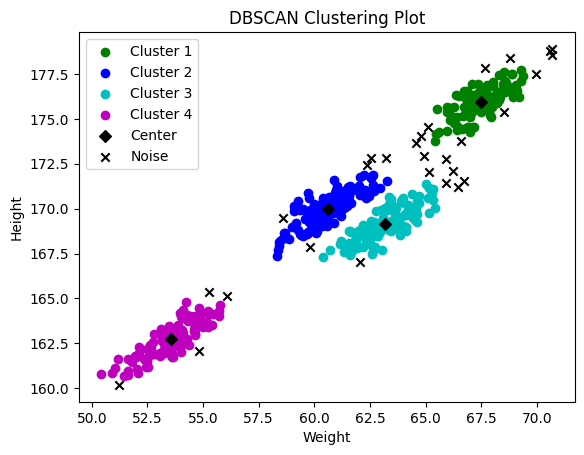

DBI指数为 0.8754619067093281


In [218]:
# your code here
colors = ['r', 'g', 'b', 'c', 'm']

# 在这里补全画图的代码
for cluster in range(1, cur_cluster + 1):
    cluster_points_x = [point[0] for point in clusters[cluster]]
    cluster_points_y = [point[1] for point in clusters[cluster]]
    
    # 绘制簇的数据点
    plt.scatter(cluster_points_x, cluster_points_y, label=f'Cluster {cluster}', c=colors[cluster % len(colors)])

cluster_center_x = [cluster_centers[i][0] for i in range(len(cluster_centers))]
cluster_center_y = [cluster_centers[i][1] for i in range(len(cluster_centers))]
plt.scatter(cluster_center_x, cluster_center_y, label='Center', color='k', marker='D')

# 绘制未分类的点
noise_points_x = [D[i][0] for i in range(len(D)) if labels[i] == 0]
noise_points_y = [D[i][1] for i in range(len(D)) if labels[i] == 0]
plt.scatter(noise_points_x, noise_points_y, label='Noise', c='k', marker='x')

plt.legend()
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('DBSCAN Clustering Plot')
plt.show()

new_clusters = {key - 1: value for key, value in clusters.items()}
print("DBI指数为",davies_bouldin_index(cluster_centers, new_clusters))

**<font color = blue size=4>第二部分:作业提交</font>**

一、实验课下课前提交完成代码，如果下课前未完成，请将已经完成的部分进行提交，未完成的部分于之后的实验报告中进行补充  
要求:  
1)文件格式为：学号-姓名.ipynb  
2)【不要】提交文件夹、压缩包、数据集等无关文件，只需提交单个ipynb文件即可，如果交错请到讲台前联系助教，删掉之前的错误版本后再进行提交

二、本次实验报告下周（11.3 14:20）交  
要求：  
1)文件格式为：学号-姓名.pdf  
2)【不要】提交文件夹、压缩包、代码文件、数据集等任何与实验报告无关的文件，只需要提交单个pdf文件即可  
3)文件命名时不需要额外添加“实验几”等额外信息，按照格式提交  
4)每周的实验报告提交地址会变化，且有时间限制，提交时间为下周的实验课开始时，请注意及时提交。

实验七(聚类)的实验报告:  
截止时间：2023-11-3 14:20  
提交地址：https://send2me.cn/iELj8D1c/SQ2D4iOn-q0vHQ

三、课堂课件获取地址:https://www.jianguoyun.com/p/DU6WTlcQp5WhChiKxZkFIAA  
实验内容获取地址:https://www.jianguoyun.com/p/DTeJc2sQp5WhChiv96IFIAA